In [3]:
%run _utils.ipynb

In [4]:
gk_issues = load_gk_issues_for_analysis()
non_gk_issues = load_non_gk_issues_for_analysis()

<h3>How many issues does each project?</h3>

In [5]:
gk_issues.groupby('repo_name', observed=True).size().describe()

count    9632.000000
mean       10.773983
std        30.134494
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max      1781.000000
dtype: float64

In [6]:
non_gk_issues.groupby('repo_name', observed=True).size().describe()

count    6824.000000
mean       41.845692
std       250.268658
min         1.000000
25%         1.000000
50%         4.000000
75%        14.000000
max      9633.000000
dtype: float64

<h3>Add stargazers and other repo info</h3>

In [7]:
dtypes = {
    'repo_name': 'category',
    'is_fork': 'bool',
    'size': 'int64',
    'stargazers_count': 'int64',
    'watchers_count': 'int64',
    'language': 'category'
}
gkir_repos_info_gh = pd.read_csv(f'../csv/gkir_repos_info.csv', dtype=dtypes)

dtypes = {
    'repo_name': 'category',
    'package_name': 'category',
    'use_repo_name': 'bool',
    'on_libraries_io_npm': 'bool',
    'npm_dependent_repos_count': 'float64',
    'npm_dependents_count': 'float64',
    'npm_forks': 'float64',
    'npm_language': 'category',
    'npm_rank': 'float64',
    'npm_stars': 'float64',
}
gkir_repos_info_libraries_io = pd.read_csv(f'../csv/repo_npm_package_info_with_libraries_io.csv', dtype=dtypes)

gkir_repos_info = pd.merge(
    left=gkir_repos_info_gh,
    right=gkir_repos_info_libraries_io,
    on='repo_name'
)
gkir_repos_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9627 entries, 0 to 9626
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   repo_name                  9627 non-null   category
 1   is_fork                    9627 non-null   bool    
 2   size                       9627 non-null   int64   
 3   stargazers_count           9627 non-null   int64   
 4   watchers_count             9627 non-null   int64   
 5   language                   9585 non-null   category
 6   package_name               9627 non-null   category
 7   use_repo_name              9627 non-null   bool    
 8   on_libraries_io_npm        9627 non-null   bool    
 9   npm_dependent_repos_count  7322 non-null   float64 
 10  npm_dependents_count       7322 non-null   float64 
 11  npm_forks                  7322 non-null   float64 
 12  npm_language               6855 non-null   category
 13  npm_rank                   7322 n

<h3>Stargazers counts</h3>

In [8]:
print(gkir_repos_info['stargazers_count'].describe())

print(f"{len(gkir_repos_info[gkir_repos_info['stargazers_count'] >= 6])} of repos have >=6 stars")
print(f"{len(gkir_repos_info[gkir_repos_info['stargazers_count'] >= 10])} of repos have >=10 stars")

count     9627.000000
mean       256.176171
std       2019.148280
min          0.000000
25%          1.000000
50%          6.000000
75%         35.000000
max      69711.000000
Name: stargazers_count, dtype: float64
4818 of repos have >=6 stars
3991 of repos have >=10 stars


<h3>Popular libraries for analysis</h3>

In [9]:
popular_npm_repos = (
    gkir_repos_info.loc[
        (gkir_repos_info['stargazers_count'] >= 10) &
        (gkir_repos_info['on_libraries_io_npm'])
    ]
)
print(f'{calculate_percent(len(popular_npm_repos), len(gkir_repos_info))}% of repos are on npm and have >= 10 stargazers')

32.74% of repos are on npm and have >= 10 stargazers


In [10]:
popular_npm_repos['npm_dependent_repos_count'].describe()

count      3152.000000
mean       8367.588198
std       56968.003358
min           0.000000
25%           1.000000
50%           9.000000
75%          94.000000
max      845125.000000
Name: npm_dependent_repos_count, dtype: float64

<h3>Comparing distributions within same project</h3>

Create combined issues dataset

In [12]:
# non_gk_issues, gk_issues
non_gk_simplified = non_gk_issues[['id', 'repo_name', 'state', 'created_at', 'closed_at']].copy()
non_gk_simplified['dependency_type'] = pd.NA
non_gk_simplified['time_to_close'] = non_gk_simplified['closed_at'] - non_gk_simplified['created_at']
non_gk_simplified['time_to_close_hours'] = non_gk_simplified['time_to_close'] / np.timedelta64(1, 'h')
non_gk_simplified['type'] = 'non_gk'

In [13]:
gk_simplified = gk_issues[['id', 'repo_name', 'state', 'created_at', 'closed_at', 'dependency_type']].copy()
gk_simplified['time_to_close'] = gk_simplified['closed_at'] - gk_simplified['created_at']
gk_simplified['time_to_close_hours'] = gk_simplified['time_to_close'] / np.timedelta64(1, 'h')
gk_simplified['type'] = 'gk'

In [14]:
combined = non_gk_simplified.append(gk_simplified)
combined_closed = combined[combined['state'] == 'closed']
combined_closed = combined_closed[combined_closed['time_to_close_hours'] != 0]
# combined_closed.info()

Only do analysis for NPM projects with at least 10 GH stars

In [15]:
combined_closed = combined_closed[combined_closed['repo_name'].isin(popular_npm_repos['repo_name'])]

<h3>Median time to close values</h3>

In [16]:
combined_closed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172994 entries, 28 to 103765
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   id                   172994 non-null  int64              
 1   repo_name            172994 non-null  object             
 2   state                172994 non-null  category           
 3   created_at           172994 non-null  datetime64[ns, UTC]
 4   closed_at            172994 non-null  datetime64[ns, UTC]
 5   dependency_type      28926 non-null   object             
 6   time_to_close        172994 non-null  timedelta64[ns]    
 7   time_to_close_hours  172994 non-null  float64            
 8   type                 172994 non-null  object             
dtypes: category(1), datetime64[ns, UTC](2), float64(1), int64(1), object(3), timedelta64[ns](1)
memory usage: 12.0+ MB


In [17]:
issue_type = 'gk'
combined_closed[combined_closed['type'] == issue_type]['time_to_close'].describe()

count                         30251
mean     44 days 03:03:02.589005322
std      92 days 17:12:28.601618956
min                 0 days 00:00:08
25%                 0 days 12:13:00
50%                 6 days 00:37:20
75%                40 days 18:59:18
max              1115 days 07:04:42
Name: time_to_close, dtype: object

In [18]:
issue_type = 'non_gk'
combined_closed[combined_closed['type'] == issue_type]['time_to_close'].describe()

count                         142743
mean      61 days 12:30:41.600386709
std      140 days 07:11:24.132875110
min                  0 days 00:00:01
25%           0 days 10:32:33.500000
50%                  5 days 02:20:50
75%          50 days 11:46:20.500000
max               1506 days 12:45:41
Name: time_to_close, dtype: object

In [20]:
combined_closed['dependency_type'].value_counts()

devDependency         21529
dependency             7314
peerDependency           57
optionalDependency       26
Name: dependency_type, dtype: int64

<h3>Compare intra project GKIR and non-GKIR time to close values</h3>

In [21]:
import statsmodels
def compare_project_distributions(project_issues):
    l_ngki = project_issues[project_issues['type'] == 'non_gk']
    l_gki = project_issues[project_issues['type'] == 'gk']
    project_issue_count = len(project_issues)
    project_ngki_count = len(l_ngki)
    project_gki_count = len(l_gki)
    
    def create_return_obj(*args):
        return pd.Series([a for a in args])

    if len(l_ngki['time_to_close_hours']) == 0 or len(l_gki['time_to_close_hours']) == 0:
        return create_return_obj(project_issue_count, project_ngki_count, project_gki_count,
            None, None, None, None, None, None)
    (statistic, pvalue) = mannwhitneyu(
        l_ngki['time_to_close_hours'],
        l_gki['time_to_close_hours']
    )
    (delta, size) = cliffsDelta(
        l_ngki['time_to_close_hours'],
        l_gki['time_to_close_hours']
    )
    return create_return_obj(project_issue_count, project_ngki_count, project_gki_count,
        l_ngki['time_to_close_hours'].median(), l_gki['time_to_close_hours'].median(), statistic, pvalue, delta, size)

In [26]:
intra_project_distribution_compares = (
    combined_closed
        .groupby('repo_name')[['repo_name', 'type', 'time_to_close_hours', 'dependency_type']]
        .apply(compare_project_distributions)
)

intra_project_distribution_compares.columns = [
    'project_issue_count',
    'project_ngki_count',
    'project_gki_count',
    'median_ngki_ttc',
    'median_gki_ttc',
    'issue_type_statistic',
    'issue_type_pvalue',
    'issue_type_delta',
    'issue_type_size',
]
intra_project_distribution_compares = intra_project_distribution_compares.dropna().copy()
intra_project_distribution_compares['issue_type_significant'] = intra_project_distribution_compares['issue_type_pvalue'] < 0.05
intra_project_distribution_compares['issue_type_size'] = intra_project_distribution_compares['issue_type_size'].astype('category')


In [27]:
intra_project_distribution_compares[['project_ngki_count', 'project_gki_count']].describe()

,project_ngki_count,project_gki_count
count,2365.000000,2365.000000
mean,60.055814,11.957294
std,272.797548,25.552910
min,1.000000,1.000000
25%,3.000000,2.000000
50%,8.000000,5.000000
75%,28.000000,12.000000
max,9173.000000,643.000000


Bonferroni correction

In [33]:
import statsmodels.stats.multitest as multi
uncorrected_pvals = intra_project_distribution_compares['issue_type_pvalue'].to_numpy()
(reject, pvals_corrected, _, _) = multi.multipletests(uncorrected_pvals, alpha=0.05, method='holm')
intra_project_distribution_compares['significant_corrected'] = reject
intra_project_distribution_compares['pvalue_corrected'] = pvals_corrected

intra_project_distribution_compares.groupby(['issue_type_significant', 'significant_corrected']).size()

issue_type_significant  significant_corrected
False                   False                    1791
True                    False                     512
                        True                       62
dtype: int64

In [30]:
# Use corrected column?
SIGNIFICANT_COLUMN = 'significant_corrected'

In [34]:
sig_and_size = (
    intra_project_distribution_compares[['issue_type_significant', 'issue_type_size']]
        .value_counts()
        .to_frame(name='count')
)
sig_and_size['proportion'] = sig_and_size['count'] / sig_and_size['count'].sum()
sig_and_size

count  proportion
issue_type_significant issue_type_size                   
False                  large              693    0.293023
                       negligible         474    0.200423
True                   large              424    0.179281
False                  small              376    0.158985
                       medium             248    0.104863
True                   medium             106    0.044820
                       small               42    0.017759
                       negligible           2    0.000846

In [35]:
sig_and_size = (
    intra_project_distribution_compares[[SIGNIFICANT_COLUMN, 'issue_type_size']]
        .value_counts()
        .to_frame(name='count')
)
sig_and_size['proportion'] = sig_and_size['count'] / sig_and_size['count'].sum()
sig_and_size

count  proportion
significant_corrected issue_type_size                   
False                 large             1070    0.452431
                      negligible         476    0.201268
                      small              415    0.175476
                      medium             342    0.144609
True                  large               47    0.019873
                      medium              12    0.005074
                      small                3    0.001268

In [36]:
sig_and_size = (
    intra_project_distribution_compares
        .groupby(['issue_type_size', SIGNIFICANT_COLUMN])
        .size()
        .unstack()
        .T
)

sig_and_size = sig_and_size[['negligible', 'small', 'medium', 'large']]
sig_and_size = sig_and_size.reindex([True, False])
sig_and_size_proportions = sig_and_size.applymap(lambda x: x / sig_and_size.sum().sum())

def make_label(x):
    label = f'{round(x * 100)}%'
    if label == '0%':
        label = '<1%'
    return label
        
sig_and_size_labels = sig_and_size_proportions.applymap(lambda x: make_label(x))

Saving figure time_to_close_project_distribution_significant_effect_size_table


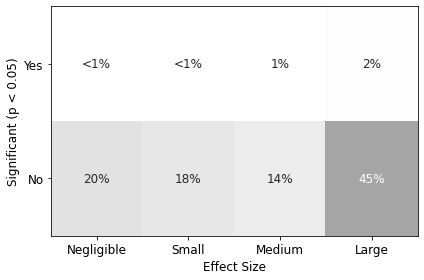

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

sns.heatmap(
    sig_and_size_proportions,
    annot=sig_and_size_labels,
    annot_kws={
        'fontsize': 12
    },
    fmt='',
    cbar=False,
    square=False,
    ax=ax,
    cmap=plt.get_cmap('Greys'),
    vmin=0,
    vmax=1,
)

ax.set_xlabel('Effect Size', fontsize=12)
ax.set_xticklabels(['Negligible', 'Small', 'Medium', 'Large'], rotation=0, fontsize=12)

ax.set_ylabel('Significant (p < 0.05)', fontsize=12)
ax.set_yticklabels(['Yes', 'No'], rotation=0, fontsize=12)

for _, spine in ax.spines.items():
    spine.set_visible(True)

    
save_fig('time_to_close_project_distribution_significant_effect_size_table')

plt.show()

In [39]:
intra_project_distribution_compares_simplified = intra_project_distribution_compares.copy()
intra_project_distribution_compares_simplified['my_effect_size'] = 'not_significant'
valid_sizes = ['small', 'medium', 'large']
for s in valid_sizes:
    intra_project_distribution_compares_simplified.loc[
        (
            (intra_project_distribution_compares_simplified[SIGNIFICANT_COLUMN]) &
            (intra_project_distribution_compares_simplified['issue_type_size'] == s)
        ),
        'my_effect_size'
    ] = s

intra_project_distribution_compares_simplified['my_effect_size'] = (
    intra_project_distribution_compares_simplified['my_effect_size'].astype('category')
)
intra_project_distribution_compares_simplified['my_effect_size'].value_counts()

sig_and_size_simplified = intra_project_distribution_compares_simplified['my_effect_size'].value_counts()
sig_and_size_simplified = sig_and_size_simplified[['not_significant', 'small', 'medium', 'large']]
sig_and_size_simplified_proportions = sig_and_size_simplified.apply(lambda x: x / sig_and_size_simplified.sum())

def make_label(x):
    label = f'{round(x * 100, 1)}%'
    if label == '0%':
        label = '<1%'
    return label
        
sig_and_size_simplified_labels = sig_and_size_simplified_proportions.apply(lambda x: make_label(x))

sig_and_size_simplified_proportions.to_frame().T

,not_significant,small,medium,large
my_effect_size,0.973784,0.001268,0.005074,0.019873


Saving figure time_to_close_project_distribution_significant_effect_size_table_simplified


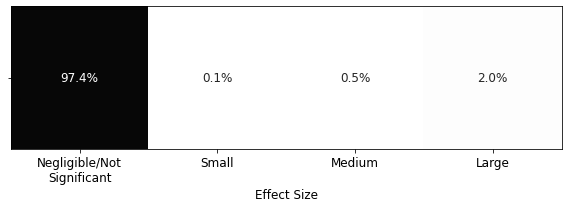

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))

sns.heatmap(
    sig_and_size_simplified_proportions.to_frame().T,
    annot=sig_and_size_simplified_labels.to_frame().T,
    annot_kws={
        'fontsize': 12
    },
    fmt='',
    cbar=False,
    square=False,
    ax=ax,
    cmap=plt.get_cmap('Greys'),
    vmin=0,
    vmax=1,
)

ax.set_xlabel('Effect Size', fontsize=12)
ax.set_xticklabels(['Negligible/Not\nSignificant', 'Small', 'Medium', 'Large'], rotation=0, fontsize=12)

ax.set_ylabel('')
ax.set_yticklabels('')

for _, spine in ax.spines.items():
    spine.set_visible(True)

    
save_fig('time_to_close_project_distribution_significant_effect_size_table_simplified')

plt.show()

In [41]:
for_table = (
    intra_project_distribution_compares_simplified[
        ['median_ngki_ttc', 'median_gki_ttc', 'my_effect_size']
    ].copy()
)

for_table['td_median_ngki_ttc'] = pd.to_timedelta(for_table['median_ngki_ttc'], unit='h')
for_table['td_median_gki_ttc'] = pd.to_timedelta(for_table['median_gki_ttc'], unit='h')
for_table = (
    for_table
        .groupby('my_effect_size')[['median_ngki_ttc', 'median_gki_ttc']]
        .median()
        .applymap(lambda x: pd.to_timedelta(x, unit='h'))
)

print('Median times for each effect size')
for_table.head()

Median times for each effect size


,median_ngki_ttc,median_gki_ttc
my_effect_size,,
large,7 days 17:03:45,0 days 07:12:49.500000
medium,4 days 18:20:34.249999200,0 days 15:30:21.750001200
not_significant,6 days 13:20:32.499999600,11 days 22:41:03.500001600
small,5 days 02:15:55.000000800,1 days 13:13:07.500000


In [43]:
m_o_l = ['medium', 'large']
only_med_and_large = (
    intra_project_distribution_compares_simplified[
        intra_project_distribution_compares_simplified['my_effect_size'].isin(m_o_l)
    ][
        ['median_ngki_ttc', 'median_gki_ttc', 'my_effect_size']
    ].copy()
)

print(f'''
For Medium and Large effect size:
    Median for Non GKIR - {pd.to_timedelta(only_med_and_large['median_ngki_ttc'].median(), unit='h')}
    Median for GKIR - {pd.to_timedelta(only_med_and_large['median_gki_ttc'].median(), unit='h')}
''')


For Medium and Large effect size:
    Median for Non GKIR - 6 days 08:37:14.000001600
    Median for GKIR - 0 days 10:34:35.000000399



<h3>Dev vs. Runtime Dependencys</h3>

In [44]:
gk_combined_closed = combined_closed[combined_closed['type'] == 'gk'].copy()
deps = ['devDependency', 'dependency']
gk_combined_closed = gk_combined_closed[gk_combined_closed['dependency_type'].isin(deps)]

In [45]:
gk_combined_closed['dependency_type'].value_counts() / gk_combined_closed['dependency_type'].count()

devDependency    0.74642
dependency       0.25358
Name: dependency_type, dtype: float64

In [49]:
deps = ['devDependency', 'dependency']
gk_combined_closed = gk_combined_closed[gk_combined_closed['dependency_type'].isin(deps)]
for_plot = gk_combined_closed[['dependency_type', 'time_to_close', 'time_to_close_hours']].copy()
for_plot['time_to_close_hours_log'] = np.log10(for_plot['time_to_close_hours'])
for_plot['placeholder'] = ''

(statistic, pvalue) = mannwhitneyu(
    gk_combined_closed[gk_combined_closed['dependency_type'] == 'devDependency']['time_to_close_hours'],
    gk_combined_closed[gk_combined_closed['dependency_type'] == 'dependency']['time_to_close_hours']
)
(delta, size) = cliffsDelta(
    gk_combined_closed[gk_combined_closed['dependency_type'] == 'devDependency']['time_to_close_hours'],
    gk_combined_closed[gk_combined_closed['dependency_type'] == 'dependency']['time_to_close_hours']
)

print(f'''
{gk_combined_closed[gk_combined_closed['dependency_type'] == 'devDependency']['time_to_close'].median()}
{gk_combined_closed[gk_combined_closed['dependency_type'] == 'dependency']['time_to_close'].median()}
''')
print(pvalue)
print(delta)
print(size)


6 days 12:48:48
5 days 17:48:07

4.929122517543197e-06
0.03454025605210658
negligible


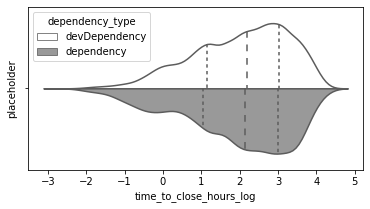

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
sns.violinplot(
    data=for_plot,
    x='time_to_close_hours_log',
    y='placeholder',
    hue='dependency_type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    scale='width',
)
# ax.set_ylabel('')
# ax.set_xlabel('Proportion of project issues that are in-range breaking build update issues.')
# ax.legend(
#     title='',
# )
# L = plt.legend(
#     loc='upper center',
#     fontsize='small',
#     fancybox=True,
#     bbox_to_anchor=(0.5,1.2),
#     ncol=2
# )

# L.get_texts()[0].set_text('All Projects')
# L.get_texts()[1].set_text('Project Issue Count At Least Median')

plt.show()